# Benchmarking of decomposition methods

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

Update: May, 2023

## Hardware

- Sytem: Ubuntu 18.04.5 LTS
- CPU: Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz (12 cores)
- Disk: SAMSUNG MZ7LH960HAJR-00005 (SSD)
- RAM: 64G(32Gx2) DDR4 2666MHz
- GPU: RTX2080Ti (Driver Version: 495.29.05, CUDA Version: 11.5)

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27
- openTSNE==0.6.1

## Notation

1. **We fix parrel number here to ensure our tests are free from the fluctuation of our sever (it is not fair if we test UMAP with 10 free cores and test t-SNE with 2 free cores). For most of the cases, we fix n_jobs=4.**
2. **There are some other choices in density-based clustering, for example DENCLUE and CLIQUE. We choice DBSCAN, HDBSCAN, and OPTICS for accessbility: DBSCAN and OPTICS are implements in sklearn, and HDBSCAN can be installed via pip. For Windows users, HDBSCAN is not avilable from pypi, I recommend you to build the wheel downloaded from https://www.lfd.uci.edu/~gohlke/pythonlibs/.**

## 0. Configure the environment

In [1]:
import time
import tracemalloc  # monitor memory usage
import sys, os
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# tested functions
import umap  # this is CPU-based UMAP, use cuML for GPU version
from sklearn import decomposition
from sklearn import manifold
from openTSNE import TSNE as OpenTSNE

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

# load table, used column=motif_F10
df = pd.read_csv("./Fly_dev_table.motif.F10.csv", index_col=[0,1,2], header=[0,1])
# Prior knowledge: NSUN6-like TCNA, else, NSUN2-like
df[("INFO", "Priori")] = "Type I"
df.loc[df[("INFO", "motif")].isin(["TCCA", "TCTA", "TCGA", "TCAA"]), ("INFO", "Priori")] = "Type II"
print(df)


                                                               INFO            \
                                                               ENSG      NAME   
2L@10007123@+                     FBgn0043456 CG4747    FBgn0043456    CG4747   
2L@10038800@+                     FBgn0027600 obst-B    FBgn0027600    obst-B   
2L@10058004@+                     FBgn0011823 Pen       FBgn0011823       Pen   
2L@101153@+                       FBgn0031216 CG11376   FBgn0031216   CG11376   
2L@1015176@-                      FBgn0031294 IA-2      FBgn0031294      IA-2   
...                                                             ...       ...   
XHet@68785@-                      FBgn0039945 CG17159   FBgn0039945   CG17159   
XHet@68786@-                      FBgn0039945 CG17159   FBgn0039945   CG17159   
XHet@77281@+                      FBgn0003559 su(f)     FBgn0003559     su(f)   
YHet@328017@-                     FBgn0085792 CR41509   FBgn0085792   CR41509   
dmel_mitochondrion_genome@14

## 1. One-hot encode sequence

In [2]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row[("INFO", "motif_F10")].upper()]
    # print(enc.transform(seq).toarray().reshape(-1))
    return enc.transform(seq).toarray().reshape(-1)

onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)
print(onehot_input.shape)

(8402, 105)


## 2. Run clustering

### 2.1 PCA

In [27]:
def PCA(onehot_input, df):
    # very fast
    df = df.copy()
    
    print("PCA:")
    n_components= 10
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = decomposition.PCA(n_components=n_components, random_state=42)
    model.fit(onehot_input)
    pca_output = model.transform(onehot_input)
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("PCA explained variance percentages:")
    print(model.explained_variance_ratio_ * 100)
    print("PCA time: {} sec".format(time1))
    print("PCA RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = pca_output[:, 0]
    df["Y"] = pca_output[:, 1]
    del model
    return time1, mem, df


# three times:
t1, m1, _ = PCA(onehot_input, df)
t2, m2, _ = PCA(onehot_input, df)
t3, m3, df_PCA = PCA(onehot_input, df)
PCA_time = [t1, t2, t3]
PCA_mem = [m1, m2, m3]

PCA:
PCA explained variance percentages:
[4.24965816 3.19751783 3.12594642 2.5854117  2.53030406 2.43602538
 2.30462906 2.23321967 2.13952283 2.13141701]
PCA time: 0.07403945922851562 sec
PCA RAM: 14.828001022338867 MB

PCA:
PCA explained variance percentages:
[4.24965816 3.19751783 3.12594642 2.5854117  2.53030406 2.43602538
 2.30462906 2.23321967 2.13952283 2.13141701]
PCA time: 0.06152915954589844 sec
PCA RAM: 14.828594207763672 MB

PCA:
PCA explained variance percentages:
[4.24965816 3.19751783 3.12594642 2.5854117  2.53030406 2.43602538
 2.30462906 2.23321967 2.13952283 2.13141701]
PCA time: 0.05770397186279297 sec
PCA RAM: 14.827413558959961 MB



### 2.2 Locally Linear Embedding (LLE)

In [28]:
def LLE(onehot_input, df):
    # this should takes ~3 min
    df = df.copy()
    print("LLE:")
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = manifold.LocallyLinearEmbedding(n_components=2, random_state=42, n_jobs=4)
    # model.fit(onehot_input)
    LLE_output = model.fit_transform(onehot_input)
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("LLE time: {} sec".format(time1))
    print("LLE RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = LLE_output[:, 0]
    df["Y"] = LLE_output[:, 1]
    del model
    return time1, mem, df

#t1, m1, _ = LLE(onehot_input, df)
#t2, m2, _ = LLE(onehot_input, df)
#t3, m3, df_LLE = LLE(onehot_input, df)
#LLE_time = [t1, t2, t3]
#LLE_mem = [m1, m2, m3]

### 2.3 t-SNE

In [30]:
def tSNE(onehot_input, df):
    df = df.copy()
    print("t-SNE:")
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = manifold.TSNE(n_components=2, init="random", verbose=False, random_state=42, n_jobs=4)
    # model.fit(onehot_input)
    tSNE_output = model.fit_transform(onehot_input)
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("t-SNE time: {} sec".format(time1))
    print("t-SNE RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = tSNE_output[:, 0]
    df["Y"] = tSNE_output[:, 1]
    del model
    return time1, mem, df

t1, m1, _ = tSNE(onehot_input, df)
t2, m2, _ = tSNE(onehot_input, df)
t3, m3, df_tSNE = tSNE(onehot_input, df)
tSNE_time = [t1, t2, t3]
tSNE_mem = [m1, m2, m3]

t-SNE:
t-SNE time: 24.877283573150635 sec
t-SNE RAM: 47.24379634857178 MB

t-SNE:
t-SNE time: 24.231045722961426 sec
t-SNE RAM: 47.23636341094971 MB

t-SNE:
t-SNE time: 24.16251301765442 sec
t-SNE RAM: 47.23456287384033 MB



### 2.4 Open t-SNE

In [31]:
def open_tSNE(onehot_input, df):
    # this should takes ~1.5 min
    df = df.copy()
    print("Open t-SNE:")
    time0 = time.time()
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    
    model = OpenTSNE(n_components=2, verbose=False, random_state=42, n_jobs=4)
    tSNE_fit = model.fit(onehot_input)
    tSNE_output = tSNE_fit.transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("Open t-SNE time: {} sec".format(time1))
    print("Open t-SNE RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = tSNE_output[:, 0]
    df["Y"] = tSNE_output[:, 1]
    del model
    return time1, mem, df

t1, m1, _ = open_tSNE(onehot_input, df)
t2, m2, _ = open_tSNE(onehot_input, df)
t3, m3, df_OpenTSNE = open_tSNE(onehot_input, df)
OpenTSNE_time = [t1, t2, t3]
OpenTSNE_mem = [m1, m2, m3]

Open t-SNE:
Open t-SNE time: 48.71418762207031 sec
Open t-SNE RAM: 76.28389072418213 MB

Open t-SNE:
Open t-SNE time: 48.304020166397095 sec
Open t-SNE RAM: 76.27269554138184 MB

Open t-SNE:
Open t-SNE time: 48.78062725067139 sec
Open t-SNE RAM: 76.2734432220459 MB



### 2.5 Isomap

In [32]:
def isomap(onehot_input, df):
    df = df.copy()
    print("Isomap:")
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = manifold.Isomap(n_components=2, n_jobs=4)
    isomap_output = model.fit_transform(onehot_input)

    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("Isomap time: {} sec".format(time1))
    print("Isomap RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = isomap_output[:, 0]
    df["Y"] = isomap_output[:, 1]
    del model
    return time1, mem, df

t1, m1, _ = isomap(onehot_input, df)
t2, m2, _ = isomap(onehot_input, df)
t3, m3, df_isomap = isomap(onehot_input, df)
isomap_time = [t1, t2, t3]
isomap_mem = [m1, m2, m3]

Isomap:
Isomap time: 47.62284302711487 sec
Isomap RAM: 2165.4735374450684 MB

Isomap:
Isomap time: 47.3277952671051 sec
Isomap RAM: 2165.464291572571 MB

Isomap:
Isomap time: 47.29121398925781 sec
Isomap RAM: 2165.4655199050903 MB



### 2.5 MDS

In [33]:
def MDS(onehot_input, df):
    # this should takes ~3 min
    df = df.copy()
    print("MDS:")
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = manifold.MDS(n_components=2, random_state=42, n_jobs=4)
    # model.fit(onehot_input)
    MDS_output = model.fit_transform(onehot_input)
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("MDS time: {} sec".format(time1))
    print("MDS RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = MDS_output[:, 0]
    df["Y"] = MDS_output[:, 1]
    del model
    return time1, mem, df

# SLOW!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# t1, m1, _ = MDS(onehot_input, df)
# t2, m2, _ = MDS(onehot_input, df)
# t3, m3, df_MDS = open_MDS(onehot_input, df)
# MDS_time = [t1, t2, t3]
# MDS_mem = [m1, m2, m3]

### 2.6 UMAP (native)

In [34]:
def UMAP(onehot_input, df):
    # this should takes ~20 sec  
    df = df.copy()
    print("UMAP")
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=0.01, n_neighbors=20, verbose=False, n_jobs=4)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

# https://umap-learn.readthedocs.io/en/latest/reproducibility.html
# JIT takes long time
# t0, m0, _ = UMAP(onehot_input, df)

# skip JIT
t1, m1, _ = UMAP(onehot_input, df)

t2, m2, _ = UMAP(onehot_input, df)
t3, m3, df_UMAP = UMAP(onehot_input, df)
t4, m4, _ = UMAP(onehot_input, df)
UMAP_time = [t4, t2, t3]
UMAP_mem = [m4, m2, m3]


UMAP
UMAP time: 23.524293661117554 sec
UMAP RAM: 42.62990379333496 MB

UMAP
UMAP time: 23.525936603546143 sec
UMAP RAM: 42.63942050933838 MB

UMAP
UMAP time: 23.377920866012573 sec
UMAP RAM: 42.61701774597168 MB

UMAP
UMAP time: 23.300545930862427 sec
UMAP RAM: 42.609426498413086 MB



### 2.7 DensMAP (Density-Preserving UMAP)

In [35]:
def densMAP(onehot_input, df):
    # this should takes ~40 sec
    print("DensMAP")
    df = df.copy()
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=0.01, n_neighbors=20, verbose=False, densmap=True, n_jobs=4)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()

    print("DensMAP time: {} sec".format(time1))
    print("DensMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

# clean JIT
model = umap.UMAP(init="random", metric="manhattan", random_state=0, n_components=2, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, n_jobs=-1)
umap_output = model.fit_transform(onehot_input)
del model
del umap_output

t1, m1, _ = densMAP(onehot_input, df)
t2, m2, _ = densMAP(onehot_input, df)
t3, m3, df_densUMAP = densMAP(onehot_input, df)
densUMAP_time = [t1, t2, t3]
densUMAP_mem = [m1, m2, m3]

DensMAP
DensMAP time: 51.031562089920044 sec
DensMAP RAM: 87.24605369567871 MB

DensMAP
DensMAP time: 52.7351336479187 sec
DensMAP RAM: 82.55511379241943 MB

DensMAP
DensMAP time: 54.065181732177734 sec
DensMAP RAM: 86.0793571472168 MB



## 3. Bechmarking

### 3.1 Comparing runtime

        Method  Time (seconds)
0          PCA        0.081385
1          PCA        0.078691
2          PCA        0.076406
3       Isomap       56.400731
4       Isomap       58.811369
5       Isomap       58.857478
6        t-SNE       27.003048
7        t-SNE       25.259764
8        t-SNE       25.393263
9   open t-SNE       41.979163
10  open t-SNE       41.840635
11  open t-SNE       41.644144
12        UMAP       27.830548
13        UMAP       28.199785
14        UMAP       27.693887
15     DensMAP       53.344407
16     DensMAP       59.120413
17     DensMAP       57.705783


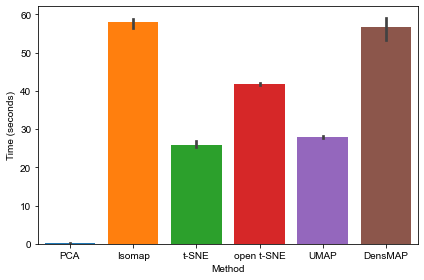

In [11]:
fig, ax = plt.subplots()
df_time = pd.DataFrame([PCA_time, isomap_time, tSNE_time, OpenTSNE_time, UMAP_time, densUMAP_time], index=["PCA", "Isomap", "t-SNE", "open t-SNE", "UMAP", "DensMAP"]).T
df_time = df_time.melt(var_name="Method", value_name="Time (seconds)")

# saving results to disk
df_time.to_csv("Decomposition_runtime.csv")

print(df_time)
sns.barplot(data=df_time, x="Method", y="Time (seconds)", ax=ax, saturation=1)

plt.tight_layout()
plt.savefig("Decomposition_runtime.pdf")
plt.show()

### 3.2 Memory usage

        Method  Peak Memory (MB)
0          PCA         14.856034
1          PCA         14.829016
2          PCA         14.828251
3       Isomap       2165.839826
4       Isomap       2165.485517
5       Isomap       2165.471211
6        t-SNE         47.305732
7        t-SNE         47.257604
8        t-SNE         47.240056
9   open t-SNE         76.388909
10  open t-SNE         76.288893
11  open t-SNE         76.281042
12        UMAP         42.621096
13        UMAP         42.636896
14        UMAP         42.643743
15     DensMAP         85.524118
16     DensMAP         87.093572
17     DensMAP         87.493746


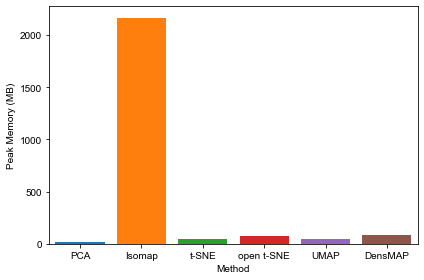

In [12]:
fig, ax = plt.subplots()
df_mem = pd.DataFrame([PCA_mem, isomap_mem, tSNE_mem, OpenTSNE_mem, UMAP_mem, densUMAP_mem], index=["PCA", "Isomap", "t-SNE", "open t-SNE", "UMAP", "DensMAP"]).T
df_mem = df_mem.melt(var_name="Method", value_name="Peak Memory (MB)")

# saving results to disk
df_mem.to_csv("Decomposition_Mem.csv")

print(df_mem)
sns.barplot(data=df_mem, x="Method", y="Peak Memory (MB)", ax=ax, saturation=1)
plt.tight_layout()
plt.savefig("Decomposition_Mem.pdf")
plt.show()

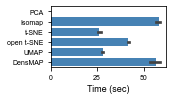

In [44]:
fig, ax = plt.subplots(figsize=(2.5, 1.5))
sns.barplot(data=df_time, y="Method", x="Time (seconds)", orient="h", ax=ax, saturation=1, color="steelblue")
ax.set_ylabel("")
ax.set_xlabel("Time (sec)", size=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig("Decomposition_time.h.pdf")

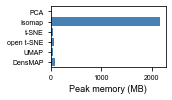

In [46]:
fig, ax = plt.subplots(figsize=(2.5, 1.5))
sns.barplot(data=df_mem, y="Method", x="Peak Memory (MB)", orient="h", ax=ax, saturation=1, color="steelblue")
ax.set_ylabel("")
ax.set_xlabel("Peak memory (MB)", size=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig("Decomposition_mem.h.pdf")

### 3.3 Draw scatters

In [13]:
def draw_clusters(ax, df, xlabel, ylabel, title, save_table=True):
    # blue - Type I
    # red  - Type II
    df_TypeI = df[df[("INFO", "Priori")]=="Type I"]
    df_TypeII = df[df[("INFO", "Priori")]=="Type II"]
    
    # draw scatter
    ax.scatter(df_TypeI["X"], df_TypeI["Y"], label="Type I", s=1, c="#4C7FB4")
    ax.scatter(df_TypeII["X"], df_TypeII["Y"], label="Type II", s=1, c="#BD4651")
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if save_table == True:
        df.to_csv("{}.csv".format(title.replace(" ","_")))

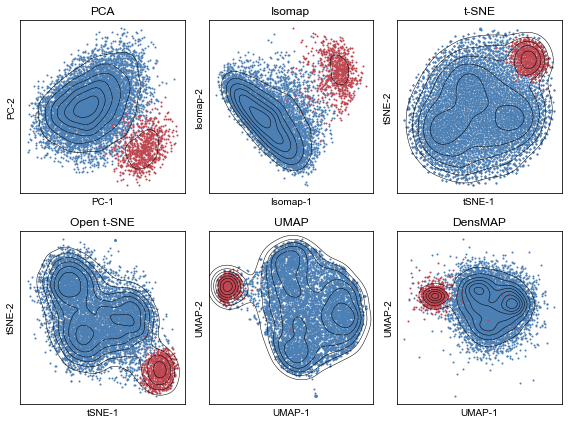

In [17]:
fig, axes = plt.subplots(2,3, figsize=(8,6))
draw_clusters(axes[0][0], df_PCA, "PC-1", "PC-2", "PCA")
draw_clusters(axes[0][1], df_isomap, "Isomap-1", "Isomap-2", "Isomap")
draw_clusters(axes[0][2], df_tSNE, "tSNE-1", "tSNE-2", "t-SNE")
draw_clusters(axes[1][0], df_OpenTSNE, "tSNE-1", "tSNE-2", "Open t-SNE")
draw_clusters(axes[1][1], df_UMAP, "UMAP-1", "UMAP-2", "UMAP")
draw_clusters(axes[1][2], df_densUMAP, "UMAP-1", "UMAP-2", "DensMAP")
plt.tight_layout()

plt.savefig("Decomposition_scatter.pdf")

In [18]:
def draw_clusters_pub(ax, df, xlabel, ylabel, title, save_table=True):
    # blue - Type I
    # red  - Type II
    df_TypeI = df[df[("INFO", "Priori")]=="Type I"]
    df_TypeII = df[df[("INFO", "Priori")]=="Type II"]
    
    # draw scatter
    ax.scatter(df_TypeI["X"], df_TypeI["Y"], label="Type I", s=1, lw=0, c="#4C7FB4")
    ax.scatter(df_TypeII["X"], df_TypeII["Y"], label="Type II", s=1, lw=0, c="#BD4651")
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    
    ax.set_xlabel(xlabel, size=6)
    ax.set_ylabel(ylabel, size=6)
    ax.set_title(title, size=9)
    ax.set_xticks([])
    ax.set_yticks([])
    if save_table == True:
        df.to_csv("{}.csv".format(title.replace(" ","_")))

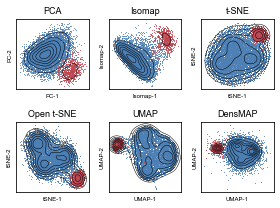

In [19]:
fig, axes = plt.subplots(2,3, figsize=(4,3))
draw_clusters_pub(axes[0][0], df_PCA, "PC-1", "PC-2", "PCA")
draw_clusters_pub(axes[0][1], df_isomap, "Isomap-1", "Isomap-2", "Isomap")
draw_clusters_pub(axes[0][2], df_tSNE, "tSNE-1", "tSNE-2", "t-SNE")
draw_clusters_pub(axes[1][0], df_OpenTSNE, "tSNE-1", "tSNE-2", "Open t-SNE")
draw_clusters_pub(axes[1][1], df_UMAP, "UMAP-1", "UMAP-2", "UMAP")
draw_clusters_pub(axes[1][2], df_densUMAP, "UMAP-1", "UMAP-2", "DensMAP")
plt.tight_layout()

plt.savefig("Decomposition_scatter.mainfigure.pdf")

## 4. Comparing UMAP metrics for onehot-encoded data

In [15]:
def UMAP_metrics(onehot_input, df, metric=None):
    # this should takes ~20 sec  
    df = df.copy()
    print("Metric = {}".format(metric))
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42,  n_components=2, min_dist=0.01, n_neighbors=20, verbose=False, metric=metric, n_jobs=4)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df
# minkowski style
# place manhattan first to clean JIT
metrics_set1 = ['manhattan', 'euclidean', 'minkowski', 'chebyshev']
# binary
metrics_set2 = ['hamming', 'dice', 'jaccard', 'russellrao', 'kulsinski', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule']

### 4.1 Test Minkowski-style ones

In [16]:
UMAP_out = []
Time_out = []
MEM_out = []

for m in metrics_set1:
    for _ in range(1):  # we only test JIT time, no longer use 3 replicates
        time1, mem, df_out = UMAP_metrics(onehot_input, df, metric=m)
        Time_out.append(time1)
        MEM_out.append(mem)
    UMAP_out.append(df_out.copy())

Metric = manhattan
UMAP time: 27.89738965034485 sec
UMAP RAM: 42.646907806396484 MB

Metric = euclidean
UMAP time: 27.909963130950928 sec
UMAP RAM: 42.61557960510254 MB

Metric = minkowski


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))
for ax, df, m in zip(*[axes.reshape(-1), UMAP_out, metrics_set1]):
    draw_clusters(ax, df, "UMAP-1", "UMAP-2", m)
plt.tight_layout()
plt.savefig("Decomposition_UMAP_metrics.Minkowski.pdf")

### 4.2 Test binary metrics

In [ ]:
# too noisy, supress warnings
import warnings
warnings.filterwarnings('ignore')

UMAP_out2 = []
Time_out2 = []
MEM_out2 = []
for m in metrics_set2:
    for _ in range(1):
        time1, mem, df_out = UMAP_metrics(onehot_input, df, metric=m)
        Time_out2.append(time1)
        MEM_out2.append(mem)
    UMAP_out2.append(df_out.copy())

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for ax, df, m in zip(*[axes.reshape(-1), UMAP_out2, metrics_set2]):
    draw_clusters(ax, df, "UMAP-1", "UMAP-2", m)
plt.tight_layout()
plt.savefig("Decomposition_UMAP_metrics.binary.pdf")

### 4.3 Draw time usage and memory usage

In [ ]:
metrics_group = ["Minkowski-style"] * 4 * 1 + ["Binary"] * 9 * 1
metrics_set_items = []
for i in metrics_set1:
    metrics_set_items.extend([i] * 1)
for i in metrics_set2:
    metrics_set_items.extend([i] * 1)
    
print(len(metrics_group))
print(len(metrics_group))
print(len(Time_out + Time_out2))
print(len(MEM_out+MEM_out2))
df_metrics_performance = pd.DataFrame(np.stack([metrics_set_items, metrics_group, Time_out + Time_out2, MEM_out+MEM_out2], axis=1), columns=["Metric", "Type", "Time (sec)", "Peak Memory (MB)"])
print(df_metrics_performance)
df_metrics_performance["Time (sec)"] = df_metrics_performance["Time (sec)"].astype(float)
df_metrics_performance["Peak Memory (MB)"] = df_metrics_performance["Peak Memory (MB)"].astype(float)
print(df_metrics_performance)
df_metrics_performance.to_csv("UMAP_metrics_performance.csv")

In [ ]:
tracemalloc.stop()

In [ ]:
fig, ax = plt.subplots()

sns.barplot(data=df_metrics_performance, y="Metric", x="Time (sec)", ax=ax, saturation=1, orient="h", color="steelblue")
ax.set_ylabel("")
ax.set_xlabel("Time (sec)")
plt.savefig("Decomposition_UMAP_metrics_time.pdf")

In [ ]:
fig, ax = plt.subplots()

sns.barplot(data=df_metrics_performance, y="Metric", x="Peak Memory (MB)", ax=ax, saturation=1, orient="h", color="steelblue")
ax.set_ylabel("")
ax.set_xlabel("Peak Memory (MB)")
plt.savefig("Decomposition_UMAP_metrics_RAM.pdf")

## Summary

UMAP is the best choice for us handling one-hot encoded fasta sequences. Although DensMAP also genrate perfect results, however, it is not suitable in distinguishing some motifs highly similar to each other (see `HeLa_Noc` notebook). PCA, is just a reference in this analysis, beacuse we know that such a statistical methods is limitted and can easily make errors. t-SNE, once popular in single-cell analysis, will break the spatial relationship in some clusters.

Among the metrics we tested, the default (`euclidean`) works perfectly. Other metrics, except for `chebyshev`, work equally. But in most of the cases, binary metrics require much more memory.

Note that, `minkowski` is the default metric in RAPIDS.
